In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

# Import โมเดลและเครื่องมือจาก scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Path ไปยังไฟล์ข้อมูล (ใช้ '../' เพื่อถอยกลับไป 1 ชั้น)
data_path = '../data/train.csv'

# โหลดข้อมูล
try:
    df_raw = pd.read_csv(data_path)
    print(f"Data loaded successfully: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
    
    # แสดงตัวอย่าง 5 แถวแรก
    display(df_raw.head())
    
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")
    print("Please ensure 'train.csv' is in the 'data/' folder.")

Data loaded successfully: 2662 rows, 427 columns


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 1. สร้างคอลัมน์ 'mol' (RDKit molecule object)
df_raw['mol'] = df_raw['SMILES'].apply(lambda smiles: Chem.MolFromSmiles(smiles))

# 2. สร้างฟีเจอร์พื้นฐานที่เราคุยกัน (Physics-Informed)
df_raw['mol_weight'] = df_raw['mol'].apply(Descriptors.MolWt)
df_raw['num_h_donors'] = df_raw['mol'].apply(Descriptors.NumHDonors)
df_raw['num_h_acceptors'] = df_raw['mol'].apply(Descriptors.NumHAcceptors)
df_raw['tpsa'] = df_raw['mol'].apply(Descriptors.TPSA) # Total Polar Surface Area
df_raw['num_rotatable_bonds'] = df_raw['mol'].apply(Descriptors.NumRotatableBonds)
df_raw['mol_logp'] = df_raw['mol'].apply(Descriptors.MolLogP) # Polarity

# 3. แสดงผล DataFrame ใหม่ที่มีฟีเจอร์เพิ่มเข้ามา
print("New features calculated:")
display(df_raw.head())

New features calculated:


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 422,Group 423,Group 424,mol,mol_weight,num_h_donors,num_h_acceptors,tpsa,num_rotatable_bonds,mol_logp
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x14ab51310>,162.032,0,0,0.00,0,2.42120
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x14ab514d0>,217.271,1,0,15.79,0,4.47430
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x14ab51540>,160.220,0,2,17.82,1,2.36462
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x14ab515b0>,84.074,1,1,37.30,0,0.09430
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x14ab51620>,118.245,1,1,0.00,3,2.49490


In [5]:
# ตรวจสอบว่ามีแถวไหนที่ 'mol' แปลงไม่สำเร็จ (เป็น None)
missing_mols = df_raw['mol'].isnull().sum()
print(f"Number of rows where SMILES failed to parse: {missing_mols}")

# เราจะลบแถวที่แปลงค่าไม่ได้ทิ้งไปเลย
# (inplace=True คือการแก้ไข DataFrame เดิมโดยตรง)
df_clean = df_raw.dropna(subset=['mol']).copy()

# ตรวจสอบข้อมูล 'melting_point' ด้วยว่ามีค่าว่าง (NaN) หรือไม่
missing_mp = df_clean['Tm'].isnull().sum()
print(f"Number of rows with missing Tm: {missing_mp}")
# (ถ้ามีค่าว่าง ก็ลบทิ้งเช่นกัน)
df_clean.dropna(subset=['Tm'], inplace=True)

print(f"Cleaned data shape: {df_clean.shape}")

Number of rows where SMILES failed to parse: 0
Number of rows with missing Tm: 0
Cleaned data shape: (2662, 434)


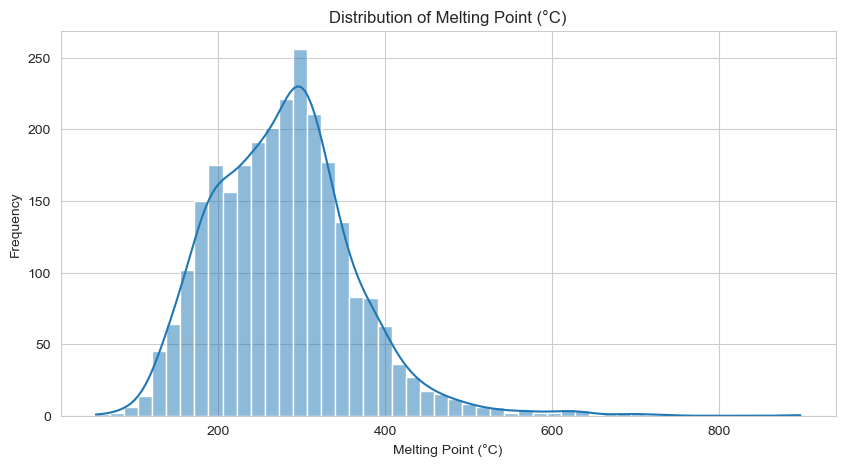

count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64

In [6]:
# ตั้งค่าสไตล์ของกราฟ
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Tm'], kde=True, bins=50)
plt.title('Distribution of Melting Point (°C)')
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# ดูค่าสถิติพื้นฐาน
display(df_clean['Tm'].describe())

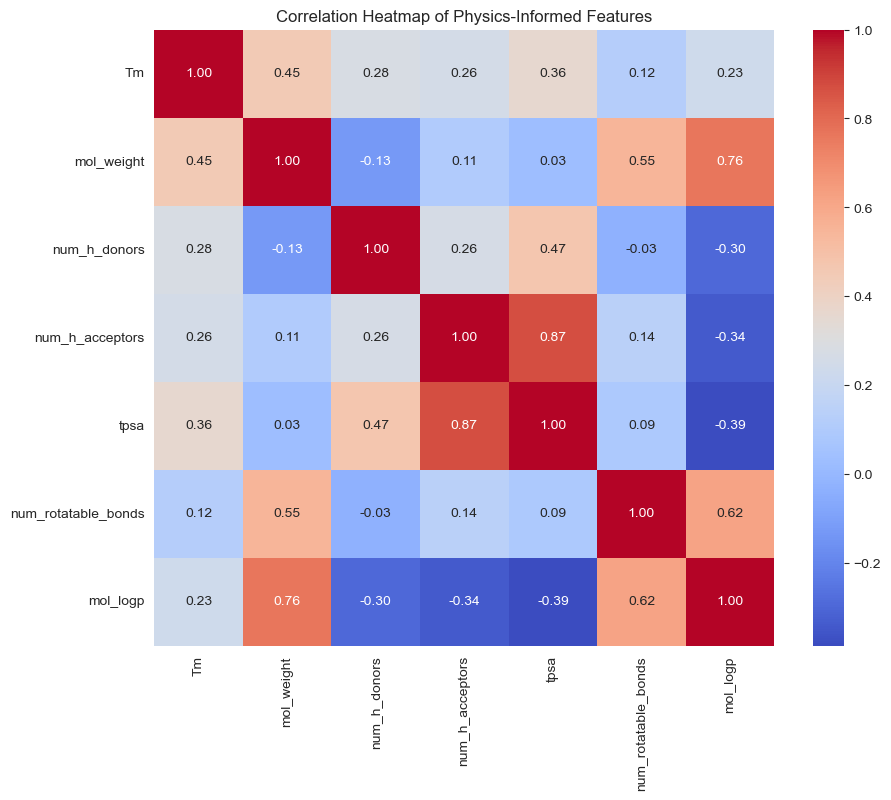

In [8]:
# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข (ฟีเจอร์) และเป้าหมาย
features_to_correlate = [
    'Tm', 
    'mol_weight', 
    'num_h_donors', 
    'num_h_acceptors', 
    'tpsa', 
    'num_rotatable_bonds',
    'mol_logp'
]

# คำนวณ Correlation Matrix
corr_matrix = df_clean[features_to_correlate].corr()

# วาด Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Physics-Informed Features')
plt.show()

In [9]:
# 1. กำหนด X (ฟีเจอร์) และ y (เป้าหมาย)
feature_names = [
    'mol_weight', 
    'num_h_donors', 
    'num_h_acceptors', 
    'tpsa', 
    'num_rotatable_bonds',
    'mol_logp'
]

X = df_clean[feature_names]
y = df_clean['Tm']

# 2. แบ่งข้อมูล (80% Train, 20% Test)
# random_state=42 คือการ "ล็อก" ผลการสุ่ม เพื่อให้ได้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 3. สเกลข้อมูล (Scaling) - (สำคัญมากสำหรับ Linear Regression/Lasso)
# เราจะ "ปรับ" ให้ฟีเจอร์ทุกตัวมีค่าเฉลี่ย=0 และ ส่วนเบี่ยงเบน=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# แปลงกลับเป็น DataFrame เพื่อให้อ่านง่าย
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Training data shape: (2129, 6)
Testing data shape: (533, 6)


In [10]:
# เทรนโมเดล Lasso (ใช้ข้อมูลที่สเกลแล้ว)
lasso_model = Lasso(alpha=1.0) # alpha คือความ "เข้มงวด" ในการคัดฟีเจอร์
lasso_model.fit(X_train_scaled, y_train)

# ดูสัมประสิทธิ์ (Coefficients) ที่โมเดลเลือก
lasso_coeffs = pd.Series(lasso_model.coef_, index=feature_names)
print("Lasso Model Coefficients:")
print(lasso_coeffs.sort_values(ascending=False))

Lasso Model Coefficients:
tpsa                   35.095206
mol_logp               33.294720
mol_weight             29.690844
num_h_donors           18.903345
num_h_acceptors        -0.000000
num_rotatable_bonds   -28.701483
dtype: float64


In [11]:
# เทรนโมเดล Random Forest
# n_jobs=-1 คือการบอกให้ใช้ CPU ทุก Core ที่มี (ช่วยให้ M2 ของคุณทำงานเร็วขึ้น)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# ทำนายผลบน Test set
y_pred_rf = rf_model.predict(X_test_scaled)

# ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} °C")
print(f"R-squared (R²): {r2:.3f}")


--- Random Forest Performance ---
Root Mean Squared Error (RMSE): 56.56 °C
R-squared (R²): 0.573


/var/folders/c3/q6m99mw90d54s778zv_w7fkh0000gn/T/ipykernel_85308/1103485201.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette="viridis")


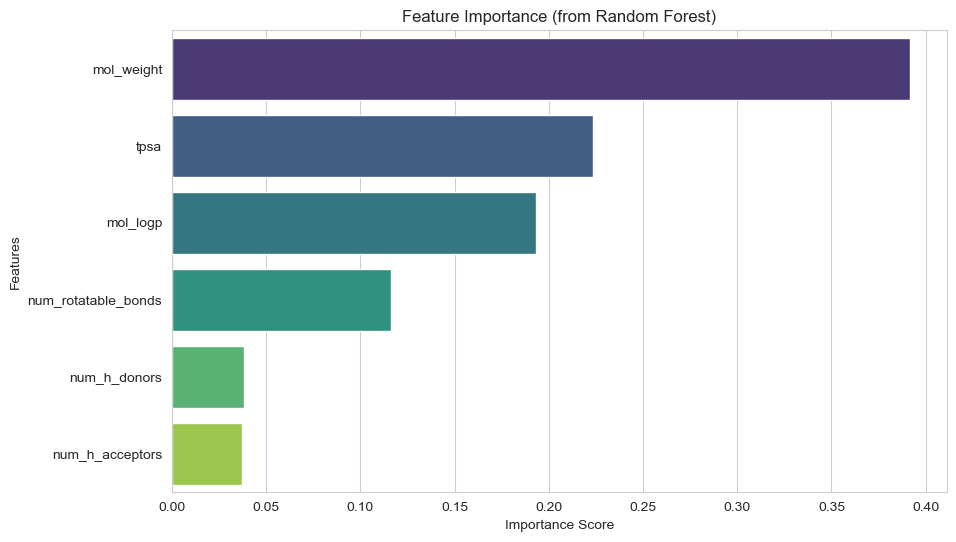

In [12]:
# ดึงค่า Feature Importance จากโมเดล Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# พล็อตกราฟ
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette="viridis")
plt.title('Feature Importance (from Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()